# Contrast Experiment Analysis: NPS vs Other Priority Schemes

This notebook analyzes the completed contrast experiment comparing NPS, FCFS, SRTF, and LRTF priority schemes under extreme conditions:
- F_tNPS_wtime_effect_bias = 50.0 (maximum sensitivity)
- F_number_of_agents = 3 (high system stress)
- 10 replications per method


In [39]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from scipy.stats import mannwhitneyu, ttest_ind
import warnings
warnings.filterwarnings('ignore')

# Set plotting style
plt.style.use('default')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (12, 8)


## 1. Load and Explore Data


In [40]:
# Load the design table
data_path = '../experiments/contrast_experiment/design_table.csv'
df = pd.read_csv(data_path)

print(f"Data shape: {df.shape}")
print(f"\nPriority schemes: {df['F_priority_scheme'].value_counts()}")
print(f"\nCompleted experiments: {df['Done'].sum()}/{len(df)}")

# Show experimental design
print("\n=== Experimental Design ===")
design_cols = ['F_priority_scheme', 'F_number_of_agents', 'F_tNPS_wtime_effect_bias', 
               'F_NPS_dist_bias', 'F_burn_in', 'F_days']
for col in design_cols:
    unique_vals = df[col].unique()
    print(f"{col}: {unique_vals}")


Data shape: (80, 57)

Priority schemes: NPS     20
FCFS    20
SRTF    20
LRTF    20
Name: F_priority_scheme, dtype: int64

Completed experiments: 80/80

=== Experimental Design ===
F_priority_scheme: ['NPS' 'FCFS' 'SRTF' 'LRTF']
F_number_of_agents: [3]
F_tNPS_wtime_effect_bias: [ 1. 10.]
F_NPS_dist_bias: [2.9]
F_burn_in: [20]
F_days: [350]


In [41]:
# Key metrics to analyze
key_metrics = [
    'closed_avg_simulated_NPS',
    'closed_avg_simulated_throughput_time', 
    'cases_closed',
    'cases_arrived',
    'Simulation_duration_min'
]

# Display summary statistics by priority scheme
print("\n=== Summary Statistics by Priority Scheme ===")
summary_stats = df.groupby('F_priority_scheme')[key_metrics].agg(['mean', 'std', 'min', 'max'])
print(summary_stats.round(4))



=== Summary Statistics by Priority Scheme ===
                  closed_avg_simulated_NPS                              \
                                      mean      std      min       max   
F_priority_scheme                                                        
FCFS                              135.1505  37.2401  91.2020  183.9180   
LRTF                              137.4423  42.0266  91.1585  185.8582   
NPS                               135.0474  39.4730  89.8388  184.0306   
SRTF                              137.3139  38.3745  94.0626  186.4572   

                  closed_avg_simulated_throughput_time                  \
                                                  mean     std     min   
F_priority_scheme                                                        
FCFS                                            0.8558  0.0350  0.7871   
LRTF                                            0.8427  0.0318  0.7990   
NPS                                             0.8653  0.0305  

## 2. Statistical Significance Testing


In [42]:
def perform_pairwise_tests(df, metric_col, group_col='F_priority_scheme'):
    """
    Perform pairwise statistical tests between all priority schemes
    """
    groups = df[group_col].unique()
    results = []
    
    for i, group1 in enumerate(groups):
        for j, group2 in enumerate(groups):
            if i < j:  # Avoid duplicate comparisons
                data1 = df[df[group_col] == group1][metric_col].dropna()
                data2 = df[df[group_col] == group2][metric_col].dropna()
                
                if len(data1) >= 3 and len(data2) >= 3:
                    # T-test (assuming normality)
                    t_stat, t_pval = ttest_ind(data1, data2)
                    
                    # Mann-Whitney U test (non-parametric)
                    u_stat, u_pval = mannwhitneyu(data1, data2, alternative='two-sided')
                    
                    # Effect size (Cohen's d)
                    pooled_std = np.sqrt(((len(data1)-1)*data1.std()**2 + (len(data2)-1)*data2.std()**2) / 
                                       (len(data1) + len(data2) - 2))
                    cohens_d = (data1.mean() - data2.mean()) / pooled_std if pooled_std > 0 else 0
                    
                    results.append({
                        'Group1': group1, 'Group2': group2,
                        'N1': len(data1), 'N2': len(data2),
                        'Mean1': data1.mean(), 'Mean2': data2.mean(),
                        'Std1': data1.std(), 'Std2': data2.std(),
                        'T_statistic': t_stat, 'T_pvalue': t_pval,
                        'U_statistic': u_stat, 'U_pvalue': u_pval,
                        'Cohens_d': cohens_d,
                        'Effect_size_interpretation': interpret_effect_size(abs(cohens_d))
                    })
    
    return pd.DataFrame(results)

def interpret_effect_size(d):
    """Interpret Cohen's d effect size"""
    if d < 0.2:
        return 'Negligible'
    elif d < 0.5:
        return 'Small'
    elif d < 0.8:
        return 'Medium'
    else:
        return 'Large'


In [43]:
# Test NPS performance
print("=== STATISTICAL TESTS: NPS Performance ===")
nps_results = perform_pairwise_tests(df, 'closed_avg_simulated_NPS')
nps_results_sorted = nps_results.sort_values('T_pvalue')

print("\n--- Pairwise Comparisons for Average Simulated NPS ---")
display_cols = ['Group1', 'Group2', 'N1', 'N2', 'Mean1', 'Mean2', 
               'T_pvalue', 'U_pvalue', 'Cohens_d', 'Effect_size_interpretation']
print(nps_results_sorted[display_cols].round(6))

# Highlight significant results
significant = nps_results_sorted[nps_results_sorted['T_pvalue'] < 0.05]
print(f"\n🎯 SIGNIFICANT DIFFERENCES (p < 0.05): {len(significant)}")
if len(significant) > 0:
    for _, row in significant.iterrows():
        direction = "higher" if row['Mean1'] > row['Mean2'] else "lower"
        print(f"   {row['Group1']} vs {row['Group2']}: {row['Group1']} has {direction} NPS")
        print(f"   → p-value: {row['T_pvalue']:.6f}, Effect size: {row['Effect_size_interpretation']} (d={row['Cohens_d']:.3f})")


=== STATISTICAL TESTS: NPS Performance ===

--- Pairwise Comparisons for Average Simulated NPS ---
  Group1 Group2  N1  N2       Mean1       Mean2  T_pvalue  U_pvalue  Cohens_d  \
2    NPS   LRTF  20  20  135.047439  137.442323  0.853623  0.542772 -0.058742   
1    NPS   SRTF  20  20  135.047439  137.313925  0.854900  0.579218 -0.058223   
4   FCFS   LRTF  20  20  135.150471  137.442323  0.856137  0.818149 -0.057721   
3   FCFS   SRTF  20  20  135.150471  137.313925  0.857380  0.903116 -0.057217   
5   SRTF   LRTF  20  20  137.313925  137.442323  0.992002  1.000000 -0.003191   
0    NPS   FCFS  20  20  135.047439  135.150471  0.993270  0.675014 -0.002685   

  Effect_size_interpretation  
2                 Negligible  
1                 Negligible  
4                 Negligible  
3                 Negligible  
5                 Negligible  
0                 Negligible  

🎯 SIGNIFICANT DIFFERENCES (p < 0.05): 0


In [44]:
# Test throughput time performance
print("\n=== STATISTICAL TESTS: Throughput Time Performance ===")
tt_results = perform_pairwise_tests(df, 'closed_avg_simulated_throughput_time')
tt_results_sorted = tt_results.sort_values('T_pvalue')

print("\n--- Pairwise Comparisons for Average Throughput Time ---")
print(tt_results_sorted[display_cols].round(6))

# Highlight significant results
significant_tt = tt_results_sorted[tt_results_sorted['T_pvalue'] < 0.05]
print(f"\n🎯 SIGNIFICANT DIFFERENCES (p < 0.05): {len(significant_tt)}")
if len(significant_tt) > 0:
    for _, row in significant_tt.iterrows():
        direction = "longer" if row['Mean1'] > row['Mean2'] else "shorter"
        print(f"   {row['Group1']} vs {row['Group2']}: {row['Group1']} has {direction} throughput time")
        print(f"   → p-value: {row['T_pvalue']:.6f}, Effect size: {row['Effect_size_interpretation']} (d={row['Cohens_d']:.3f})")



=== STATISTICAL TESTS: Throughput Time Performance ===

--- Pairwise Comparisons for Average Throughput Time ---
  Group1 Group2  N1  N2     Mean1     Mean2  T_pvalue  U_pvalue  Cohens_d  \
5   SRTF   LRTF  20  20  0.869411  0.842725  0.013636  0.016669  0.818067   
2    NPS   LRTF  20  20  0.865292  0.842725  0.027537  0.036048  0.724788   
3   FCFS   SRTF  20  20  0.855785  0.869411  0.215521  0.261616 -0.398298   
4   FCFS   LRTF  20  20  0.855785  0.842725  0.224249  0.155570  0.390682   
0    NPS   FCFS  20  20  0.865292  0.855785  0.365125  0.440750  0.289859   
1    NPS   SRTF  20  20  0.865292  0.869411  0.685974  0.860431 -0.128842   

  Effect_size_interpretation  
5                      Large  
2                     Medium  
3                      Small  
4                      Small  
0                      Small  
1                 Negligible  

🎯 SIGNIFICANT DIFFERENCES (p < 0.05): 2
   SRTF vs LRTF: SRTF has longer throughput time
   → p-value: 0.013636, Effect size: La

## 3. Visualizations


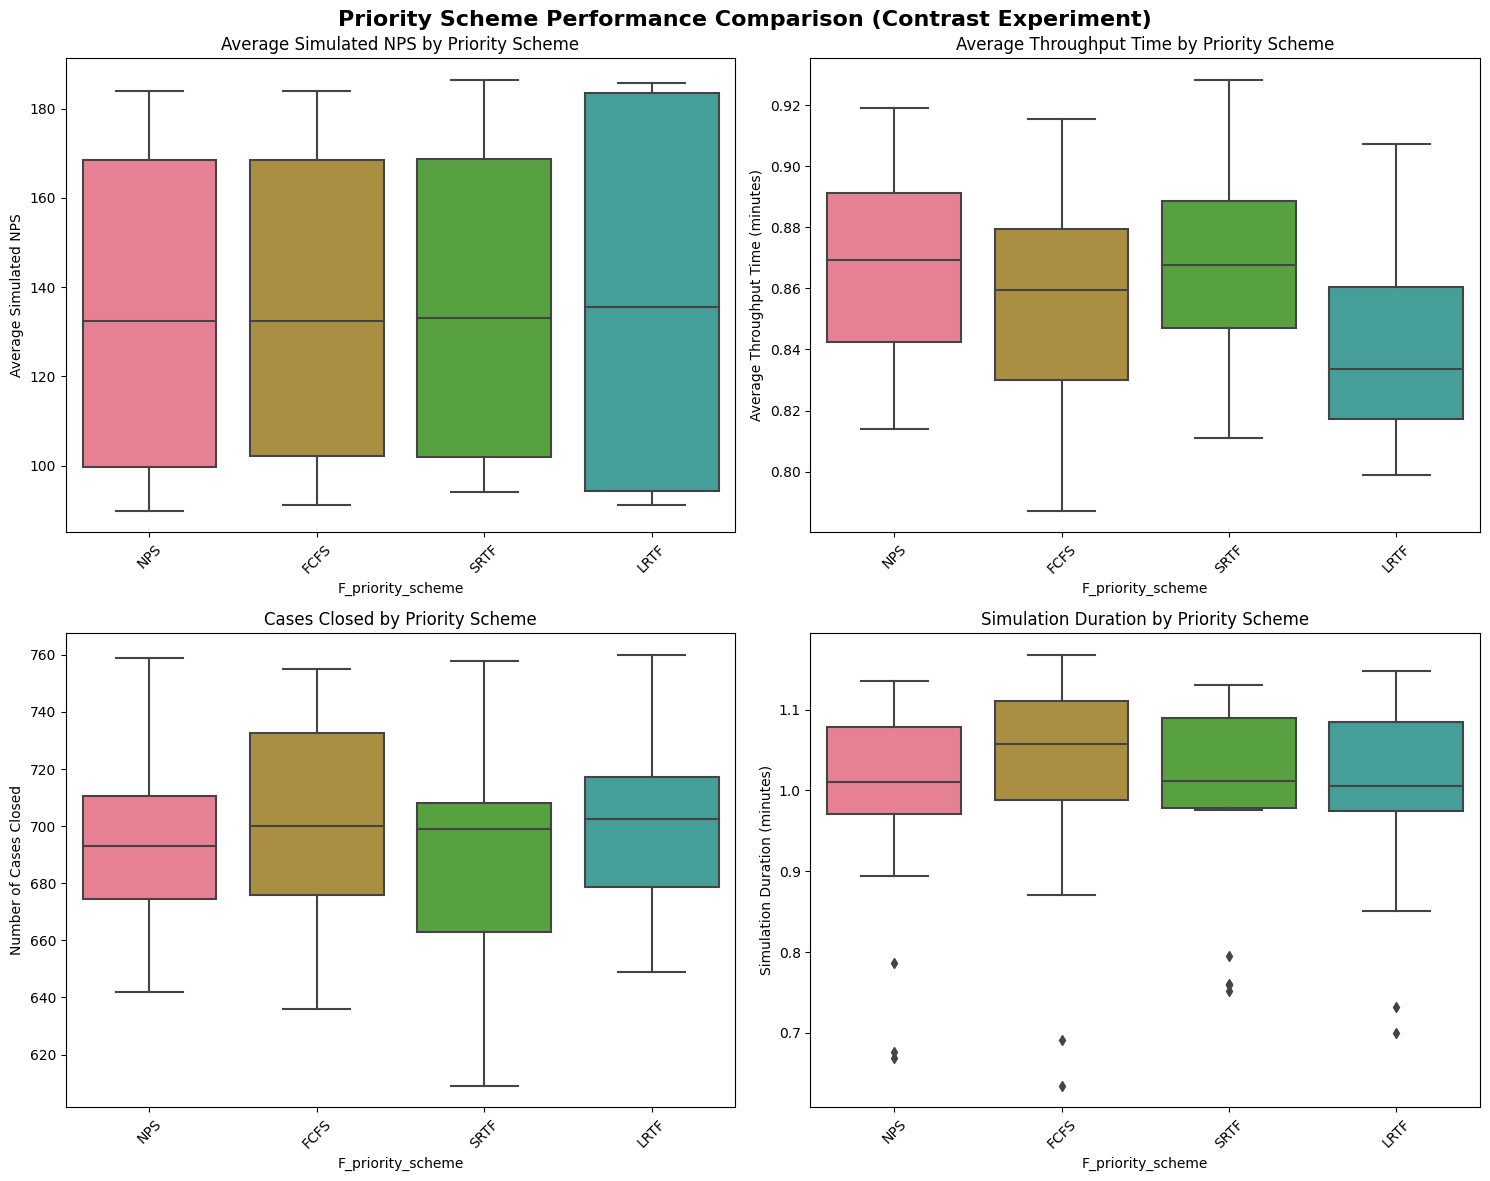

In [45]:
# Create comprehensive comparison plots
fig, axes = plt.subplots(2, 2, figsize=(15, 12))
fig.suptitle('Priority Scheme Performance Comparison (Contrast Experiment)', fontsize=16, fontweight='bold')

# NPS Distribution
sns.boxplot(data=df, x='F_priority_scheme', y='closed_avg_simulated_NPS', ax=axes[0,0])
axes[0,0].set_title('Average Simulated NPS by Priority Scheme')
axes[0,0].set_ylabel('Average Simulated NPS')
axes[0,0].tick_params(axis='x', rotation=45)

# Throughput Time Distribution  
sns.boxplot(data=df, x='F_priority_scheme', y='closed_avg_simulated_throughput_time', ax=axes[0,1])
axes[0,1].set_title('Average Throughput Time by Priority Scheme')
axes[0,1].set_ylabel('Average Throughput Time (minutes)')
axes[0,1].tick_params(axis='x', rotation=45)

# Cases Closed
sns.boxplot(data=df, x='F_priority_scheme', y='cases_closed', ax=axes[1,0])
axes[1,0].set_title('Cases Closed by Priority Scheme')
axes[1,0].set_ylabel('Number of Cases Closed')
axes[1,0].tick_params(axis='x', rotation=45)

# Simulation Duration
sns.boxplot(data=df, x='F_priority_scheme', y='Simulation_duration_min', ax=axes[1,1])
axes[1,1].set_title('Simulation Duration by Priority Scheme')
axes[1,1].set_ylabel('Simulation Duration (minutes)')
axes[1,1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()


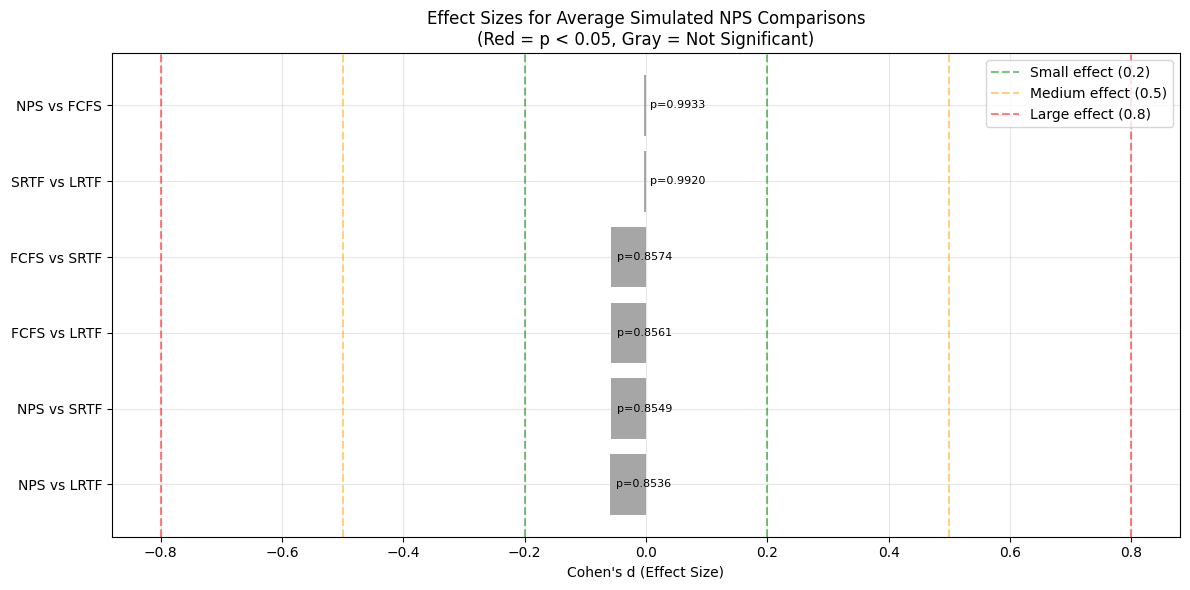

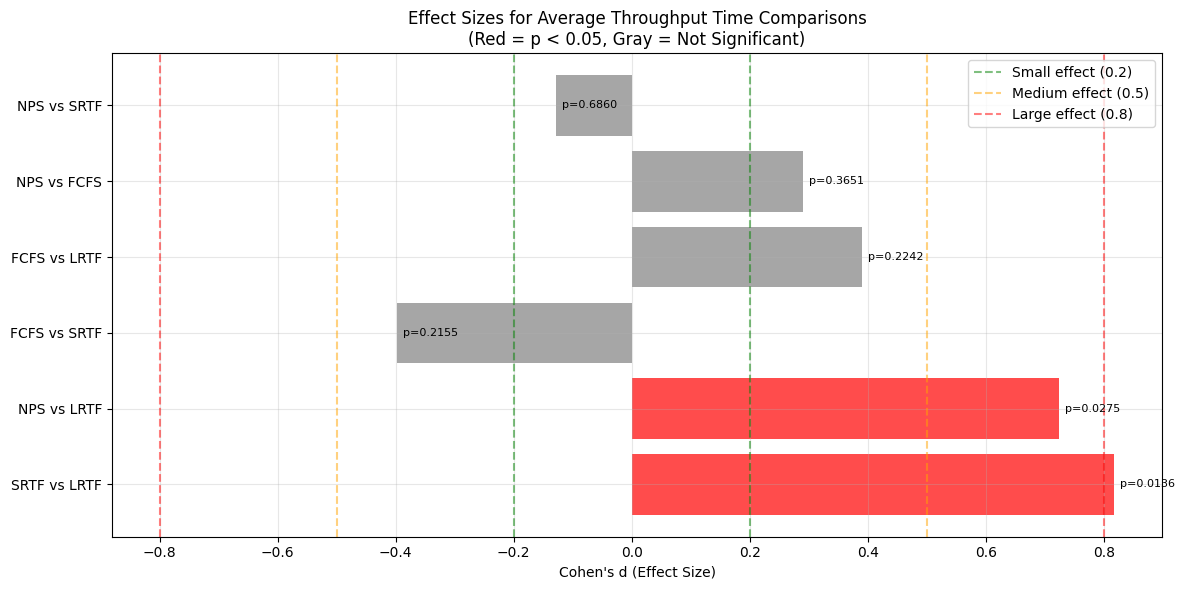

In [46]:
# Effect size visualization
def plot_effect_sizes(results_df, metric_name):
    """Plot effect sizes for pairwise comparisons"""
    fig, ax = plt.subplots(figsize=(12, 6))
    
    # Create comparison labels
    results_df['Comparison'] = results_df['Group1'] + ' vs ' + results_df['Group2']
    
    # Color by significance
    colors = ['red' if p < 0.05 else 'gray' for p in results_df['T_pvalue']]
    
    bars = ax.barh(results_df['Comparison'], results_df['Cohens_d'], color=colors, alpha=0.7)
    
    # Add effect size lines
    ax.axvline(x=0.2, color='green', linestyle='--', alpha=0.5, label='Small effect (0.2)')
    ax.axvline(x=0.5, color='orange', linestyle='--', alpha=0.5, label='Medium effect (0.5)')
    ax.axvline(x=0.8, color='red', linestyle='--', alpha=0.5, label='Large effect (0.8)')
    ax.axvline(x=-0.2, color='green', linestyle='--', alpha=0.5)
    ax.axvline(x=-0.5, color='orange', linestyle='--', alpha=0.5)
    ax.axvline(x=-0.8, color='red', linestyle='--', alpha=0.5)
    
    ax.set_xlabel("Cohen's d (Effect Size)")
    ax.set_title(f'Effect Sizes for {metric_name} Comparisons\n(Red = p < 0.05, Gray = Not Significant)')
    ax.legend()
    ax.grid(True, alpha=0.3)
    
    # Add p-values as text
    for i, (bar, pval) in enumerate(zip(bars, results_df['T_pvalue'])):
        ax.text(bar.get_width() + 0.01, bar.get_y() + bar.get_height()/2, 
               f'p={pval:.4f}', va='center', fontsize=8)
    
    plt.tight_layout()
    plt.show()

# Plot effect sizes
plot_effect_sizes(nps_results_sorted, 'Average Simulated NPS')
plot_effect_sizes(tt_results_sorted, 'Average Throughput Time')


## 4. Focus on NPS Performance


In [47]:
# Detailed NPS analysis
print("=== DETAILED NPS ANALYSIS ===")

# Calculate ranks within each replication
df_analysis = df.copy()
df_analysis['NPS_rank'] = df_analysis.groupby('repetition')['closed_avg_simulated_NPS'].rank(ascending=False)
df_analysis['TT_rank'] = df_analysis.groupby('repetition')['closed_avg_simulated_throughput_time'].rank(ascending=True)

# Summary by priority scheme
print("\n--- Performance Rankings ---")
ranking_summary = df_analysis.groupby('F_priority_scheme').agg({
    'closed_avg_simulated_NPS': ['mean', 'std'],
    'closed_avg_simulated_throughput_time': ['mean', 'std'],
    'NPS_rank': ['mean', 'std'],
    'TT_rank': ['mean', 'std'],
    'cases_closed': ['mean', 'std']
}).round(4)

print(ranking_summary)

# Count how often each method performs best
print("\n--- How Often Each Method Ranks #1 ---")
best_nps = df_analysis[df_analysis['NPS_rank'] == 1]['F_priority_scheme'].value_counts()
best_tt = df_analysis[df_analysis['TT_rank'] == 1]['F_priority_scheme'].value_counts()

print("Best NPS (highest):")
print(best_nps)
print("\nBest Throughput Time (lowest):")
print(best_tt)


=== DETAILED NPS ANALYSIS ===

--- Performance Rankings ---
                  closed_avg_simulated_NPS           \
                                      mean      std   
F_priority_scheme                                     
FCFS                              135.1505  37.2401   
LRTF                              137.4423  42.0266   
NPS                               135.0474  39.4730   
SRTF                              137.3139  38.3745   

                  closed_avg_simulated_throughput_time         NPS_rank  \
                                                  mean     std     mean   
F_priority_scheme                                                         
FCFS                                            0.8558  0.0350     4.45   
LRTF                                            0.8427  0.0318     4.30   
NPS                                             0.8653  0.0305     4.70   
SRTF                                            0.8694  0.0334     4.55   

                          TT

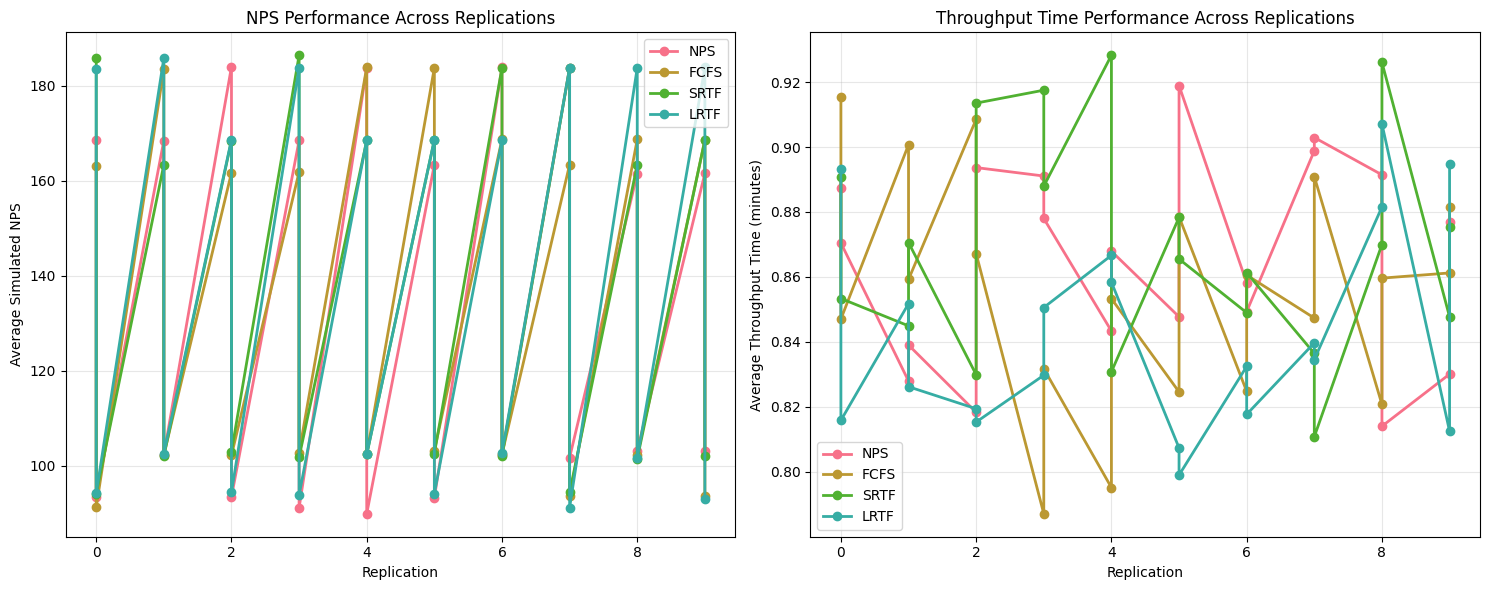

In [48]:
# Performance consistency analysis
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# NPS by replication
for scheme in df['F_priority_scheme'].unique():
    scheme_data = df[df['F_priority_scheme'] == scheme]
    axes[0].plot(scheme_data['repetition'], scheme_data['closed_avg_simulated_NPS'], 
                'o-', label=scheme, linewidth=2, markersize=6)

axes[0].set_xlabel('Replication')
axes[0].set_ylabel('Average Simulated NPS')
axes[0].set_title('NPS Performance Across Replications')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Throughput Time by replication
for scheme in df['F_priority_scheme'].unique():
    scheme_data = df[df['F_priority_scheme'] == scheme]
    axes[1].plot(scheme_data['repetition'], scheme_data['closed_avg_simulated_throughput_time'], 
                'o-', label=scheme, linewidth=2, markersize=6)

axes[1].set_xlabel('Replication')
axes[1].set_ylabel('Average Throughput Time (minutes)')
axes[1].set_title('Throughput Time Performance Across Replications')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


## 5. Summary and Conclusions


In [49]:
print("=== EXPERIMENT SUMMARY ===")
print(f"Experimental Conditions:")
print(f"  - F_tNPS_wtime_effect_bias: {df['F_tNPS_wtime_effect_bias'].iloc[0]} (maximum sensitivity)")
print(f"  - F_number_of_agents: {df['F_number_of_agents'].iloc[0]} (high system stress)")
print(f"  - F_NPS_dist_bias: {df['F_NPS_dist_bias'].iloc[0]}")
print(f"  - Replications: {df['repetition'].nunique()}")

print("\n=== KEY FINDINGS ===")

# Overall performance summary
perf_summary = df.groupby('F_priority_scheme')[['closed_avg_simulated_NPS', 
                                               'closed_avg_simulated_throughput_time',
                                               'cases_closed']].mean().round(4)
print("\nOverall Performance (Mean Values):")
print(perf_summary)

# Ranking analysis
nps_ranking = perf_summary.sort_values('closed_avg_simulated_NPS', ascending=False)
tt_ranking = perf_summary.sort_values('closed_avg_simulated_throughput_time', ascending=True)
cases_ranking = perf_summary.sort_values('cases_closed', ascending=False)

print("\n📊 PERFORMANCE RANKINGS:")
print("\n1. NPS Ranking (Higher is Better):")
for i, (scheme, row) in enumerate(nps_ranking.iterrows(), 1):
    print(f"   {i}. {scheme}: {row['closed_avg_simulated_NPS']:.6f}")

print("\n2. Throughput Time Ranking (Lower is Better):")
for i, (scheme, row) in enumerate(tt_ranking.iterrows(), 1):
    print(f"   {i}. {scheme}: {row['closed_avg_simulated_throughput_time']:.2f} minutes")

print("\n3. Cases Closed Ranking (Higher is Better):")
for i, (scheme, row) in enumerate(cases_ranking.iterrows(), 1):
    print(f"   {i}. {scheme}: {row['cases_closed']:.0f} cases")

# Statistical significance summary
sig_nps = len(nps_results[nps_results['T_pvalue'] < 0.05])
sig_tt = len(tt_results[tt_results['T_pvalue'] < 0.05])

print(f"\n🔬 STATISTICAL SIGNIFICANCE:")
print(f"   - Significant NPS differences: {sig_nps}/6 pairwise comparisons")
print(f"   - Significant Throughput Time differences: {sig_tt}/6 pairwise comparisons")

if sig_nps > 0 or sig_tt > 0:
    print("\n✅ CONCLUSION: Under these extreme conditions, meaningful differences exist between priority schemes.")
else:
    print("\n⚠️  CONCLUSION: No statistically significant differences detected between priority schemes.")


=== EXPERIMENT SUMMARY ===
Experimental Conditions:
  - F_tNPS_wtime_effect_bias: 1.0 (maximum sensitivity)
  - F_number_of_agents: 3 (high system stress)
  - F_NPS_dist_bias: 2.9
  - Replications: 10

=== KEY FINDINGS ===

Overall Performance (Mean Values):
                   closed_avg_simulated_NPS  \
F_priority_scheme                             
FCFS                               135.1505   
LRTF                               137.4423   
NPS                                135.0474   
SRTF                               137.3139   

                   closed_avg_simulated_throughput_time  cases_closed  
F_priority_scheme                                                      
FCFS                                             0.8558        703.20  
LRTF                                             0.8427        700.70  
NPS                                              0.8653        693.10  
SRTF                                             0.8694        685.95  

📊 PERFORMANCE RANKINGS:

